In [2]:
import pandas as pd
import numpy as np
import sklearn
import matplotlib as mlp
import matplotlib.pyplot as plt
import seaborn as sns
import time
import re, pip

d:\IDE\Anaconda\A\envs\fproject\lib\site-packages\_distutils_hack\__init__.py:33: UserWarning: Setuptools is replacing distutils.
  warnings.warn("Setuptools is replacing distutils.")


In [3]:
from sklearn.ensemble import RandomForestRegressor as RFR
from sklearn.model_selection import cross_validate, KFold, GridSearchCV

In [3]:
data = pd.read_csv('../data/House Price/train_encode.csv', index_col=0)

In [4]:
x = data.iloc[:, :-1]
y = data.iloc[:, -1]

In [5]:
x.shape

(1460, 80)

In [10]:
x.head()

,Id,住宅类型,住宅区域,街道接触面积(英尺),住宅面积,街道路面状况,巷子路面状况,住宅形状(大概),住宅现状,水电气,...,半开放式门廊面积,泳池面积,泳池质量,篱笆质量,其他配置,其他配置的价值,销售月份,销售年份,销售类型,销售状态
0,0.0,5.0,3.0,36.0,327.0,1.0,0.0,3.0,3.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,2.0,8.0,4.0
1,1.0,0.0,3.0,51.0,498.0,1.0,0.0,3.0,3.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,4.0,1.0,8.0,4.0
2,2.0,5.0,3.0,39.0,702.0,1.0,0.0,0.0,3.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,8.0,2.0,8.0,4.0
3,3.0,6.0,3.0,31.0,489.0,1.0,0.0,0.0,3.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,8.0,0.0
4,4.0,5.0,3.0,55.0,925.0,1.0,0.0,0.0,3.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,11.0,2.0,8.0,4.0


In [11]:
y.describe()

count      1460.000000
mean     180921.195890
std       79442.502883
min       34900.000000
25%      129975.000000
50%      163000.000000
75%      214000.000000
max      755000.000000
Name: SalePrice, dtype: float64

# 普通网格搜索

In [12]:
# 参数空间
param_grid_simple = {
    "criterion": ["squared_error", "poisson"],
    'n_estimators': [*range(20, 100, 5)],
    'max_depth': [*range(10, 25, 2)],
    'max_features': ['log2', 'sqrt', 16, 32, 64, 'auto'],
    'min_impurity_decrease': [*np.arange(0, 5, 10)],
}

In [14]:
# 参数空间大小

no_option = 1
for i in param_grid_simple:
    no_option *= len(param_grid_simple[i])

In [16]:
no_option

1536

In [17]:
# 模型，交叉验证，网格搜索
reg = RFR(random_state=442, verbose=True, n_jobs=-1)
cv = KFold(n_splits=5, shuffle=True, random_state=1412)
search = GridSearchCV(
    estimator=reg,
    param_grid=param_grid_simple,
    scoring='neg_mean_squared_error',
    verbose=True,
    cv=cv,
    n_jobs=-1,
)

In [18]:
start = time.time()
search.fit(x, y)
print(time.time() - start)

Fitting 5 folds for each of 1536 candidates, totalling 7680 fits


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.2s


2443.8752961158752


[Parallel(n_jobs=-1)]: Done  90 out of  90 | elapsed:    0.5s finished


In [19]:
2443.8752961158752/60

40.73125493526459

In [20]:
search.best_estimator_

RandomForestRegressor(criterion='poisson', max_depth=14, max_features=16,
                      min_impurity_decrease=0, n_estimators=90, n_jobs=-1,
                      random_state=442, verbose=True)

In [21]:
abs(search.best_score_) ** 0.5

29367.28357597943

In [22]:
ad_reg = RFR(n_estimators=90, max_depth=14, max_features=16, random_state=442)

In [23]:
cv = KFold(n_splits=5, shuffle=True, random_state=1412)
result_post_adjusted = cross_validate(
    ad_reg,
    x,
    y,
    cv=cv,
    scoring='neg_mean_squared_error',
    return_train_score=True,
    verbose=True,
    n_jobs=-1,
)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    7.8s remaining:   11.7s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    7.9s finished


In [27]:
result_post_adjusted

{'fit_time': array([1.68000937, 1.62584877, 1.67064762, 1.6783762 , 1.63340402]),
 'score_time': array([0.02972054, 0.02925658, 0.0372808 , 0.04160476, 0.02262855]),
 'test_score': array([-7.59501950e+08, -1.76313207e+09, -6.56423329e+08, -4.65834098e+08,
        -9.08743708e+08]),
 'train_score': array([-1.19007273e+08, -1.12214691e+08, -1.32350213e+08, -1.31270692e+08,
        -1.27692291e+08])}

In [28]:
def RMSE(cvresult, key):
    return (abs(cvresult[key]) ** 0.5).mean()

In [29]:
RMSE(result_post_adjusted, 'train_score')

11152.797783831986

In [30]:
RMSE(result_post_adjusted, 'test_score')

29379.61106939346

In [4]:
# 打包成函数供后续使用
# 评估指标RMSE
def RMSE(cvresult, key):
    return (abs(cvresult[key]) ** 0.5).mean()


# 计算参数空间大小
def count_space(param):
    no_option = 1
    for i in param_grid_simple:
        no_option *= len(param_grid_simple[i])
    print(no_option)


# 在最优参数上进行重新建模验证结果
def rebuild_on_best_param(ad_reg):
    cv = KFold(n_splits=5, shuffle=True, random_state=1412)
    result_post_adjusted = cross_validate(
        ad_reg,
        x,
        y,
        cv=cv,
        scoring="neg_mean_squared_error",
        return_train_score=True,
        verbose=True,
        n_jobs=-1,
    )
    print("训练RMSE:{:.3f}".format(RMSE(result_post_adjusted, "train_score")))
    print("测试RMSE:{:.3f}".format(RMSE(result_post_adjusted, "test_score")))

# 随机网格搜索

In [5]:
from sklearn.model_selection import RandomizedSearchCV

In [8]:
# 参数空间
param_grid_simple = {
    "criterion": ["squared_error", "poisson"],
    'n_estimators': [*range(20, 100, 5)],
    'max_depth': [*range(10, 25, 2)],
    'max_features': ['log2', 'sqrt', 16, 32, 64, 'auto'],
    'min_impurity_decrease': [*np.arange(0, 5, 10)],
}
# 建立回归器、交叉验证
reg = RFR(random_state=1412, verbose=True, n_jobs=-1)
cv = KFold(n_splits=5, shuffle=True, random_state=1412)

In [34]:
# 计算参数空间大小，这是抽样的最大值
count_space(param_grid_simple)

1536


In [35]:
# 定义随机搜索
search = RandomizedSearchCV(
    estimator=reg,
    param_distributions=param_grid_simple,
    n_iter=800,  # 子空间的大小是全域空间的一半左右
    scoring='neg_mean_squared_error',
    verbose=True,
    cv=cv,
    random_state=1412,
    n_jobs=-1,
)

In [36]:
start = time.time()
search.fit(x, y)
print(time.time() - start)

Fitting 5 folds for each of 800 candidates, totalling 4000 fits


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.1s


1429.6598687171936


[Parallel(n_jobs=-1)]: Done  85 out of  85 | elapsed:    0.4s finished


In [37]:
abs(search.best_score_) ** 0.5

29251.284326350575

In [39]:
search.best_estimator_

RandomForestRegressor(max_depth=24, max_features=16, min_impurity_decrease=0,
                      n_estimators=85, n_jobs=-1, random_state=1412,
                      verbose=True)

In [9]:
ad_reg = RFR(
    max_depth=24,
    max_features=16,
    min_impurity_decrease=0,
    n_estimators=85,
    n_jobs=-1,
    random_state=1412,
    verbose=True,
)
rebuild_on_best_param(ad_reg)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


训练RMSE:11031.299
测试RMSE:28639.969


[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    3.6s remaining:    5.4s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    3.7s finished


In [6]:
from mpl_toolkits.mplot3d import axes3d

In [13]:
p1, p2, MSE = axes3d.get_test_data(0.05)
# 自动获取数据的功能，可以自动生成符合某一分布的数据
# 我们现在假设这一组数据中有两个参数p1,p2,这两个参数组成的参数组合对应着损失函数的MSE
# 参数0.05是指参数空间中，点与点之间的距离
# 因此该参数越小，取出来的样本越多

In [14]:
len(p1)

120

In [15]:
len(p2)

120

In [16]:
MSE.shape

(120, 120)

(array([-40., -30., -20., -10.,   0.,  10.,  20.,  30.,  40.]),
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

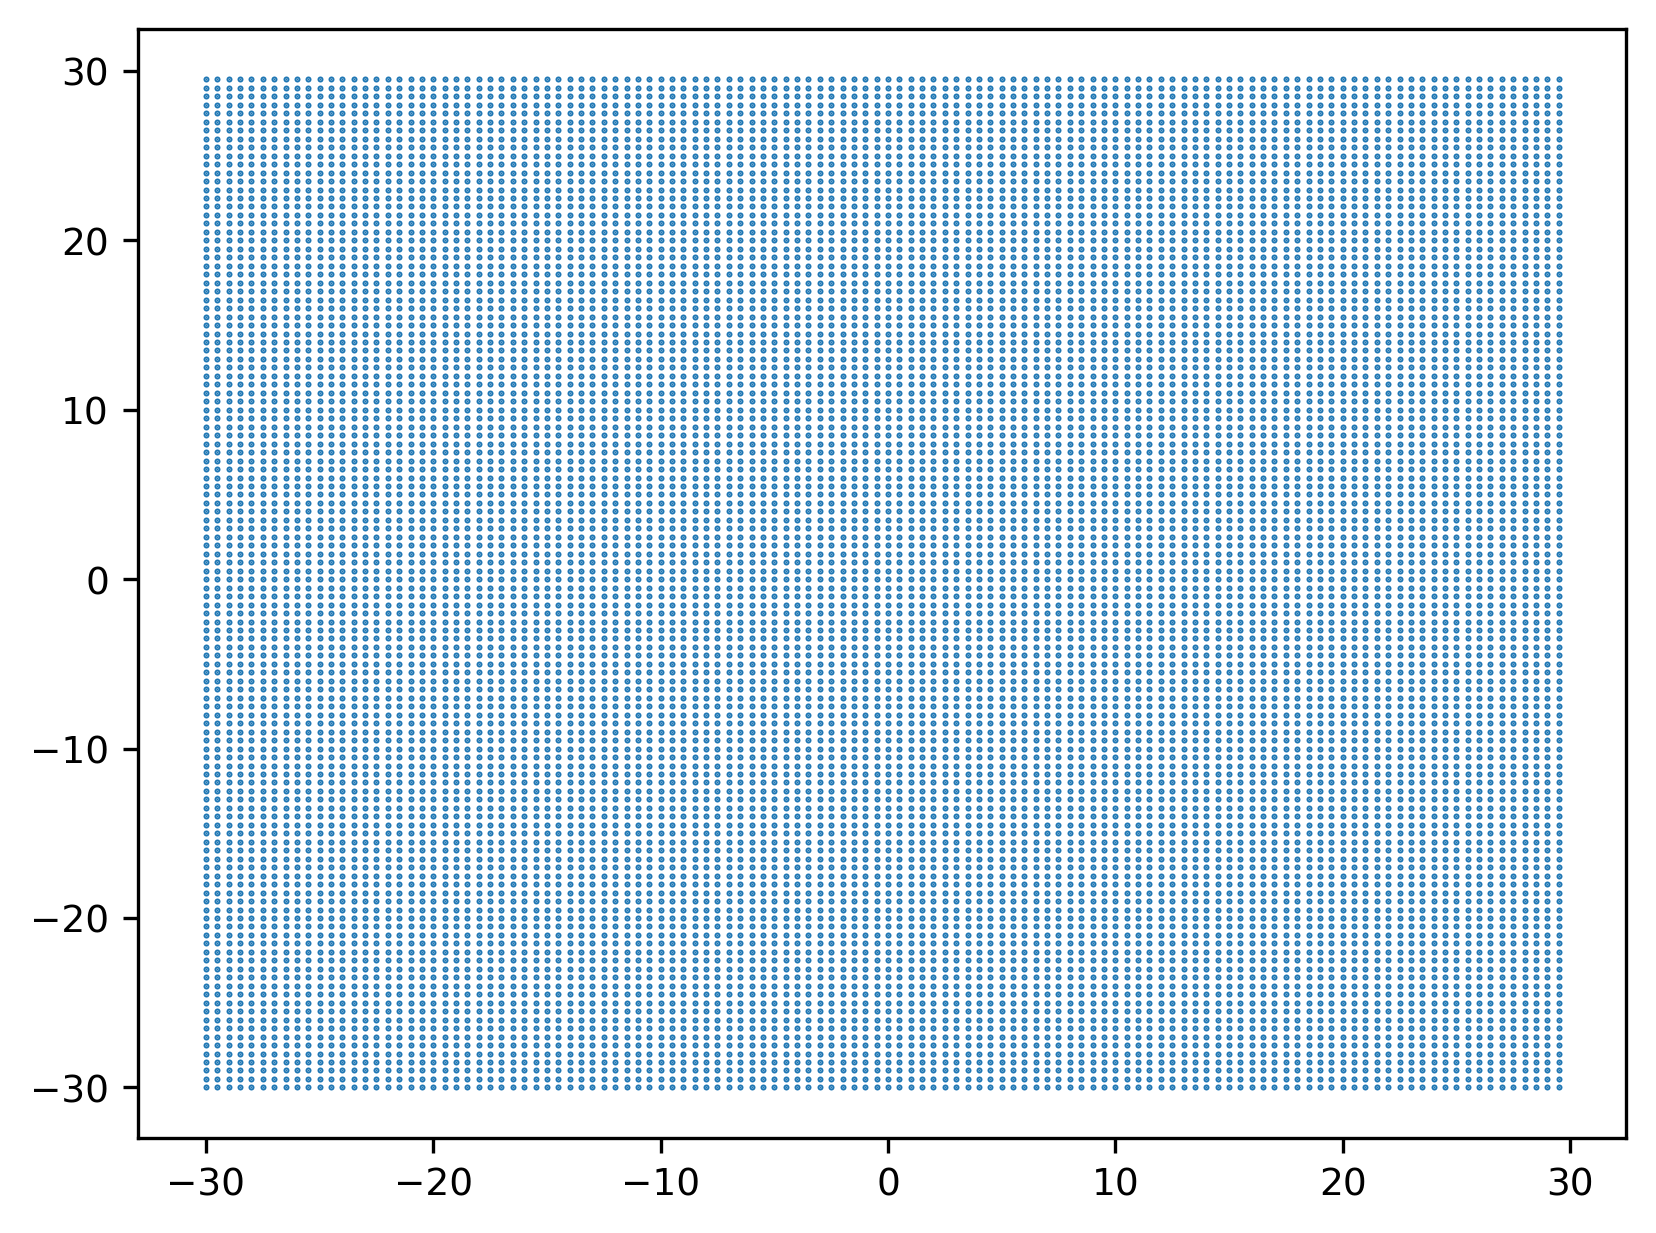

In [17]:
# 绘制p1与p2的参数空间
plt.figure(dpi=300)
plt.scatter(p1, p2, s=0.2)
plt.xticks(fontsize=9)
plt.yticks(fontsize=9)

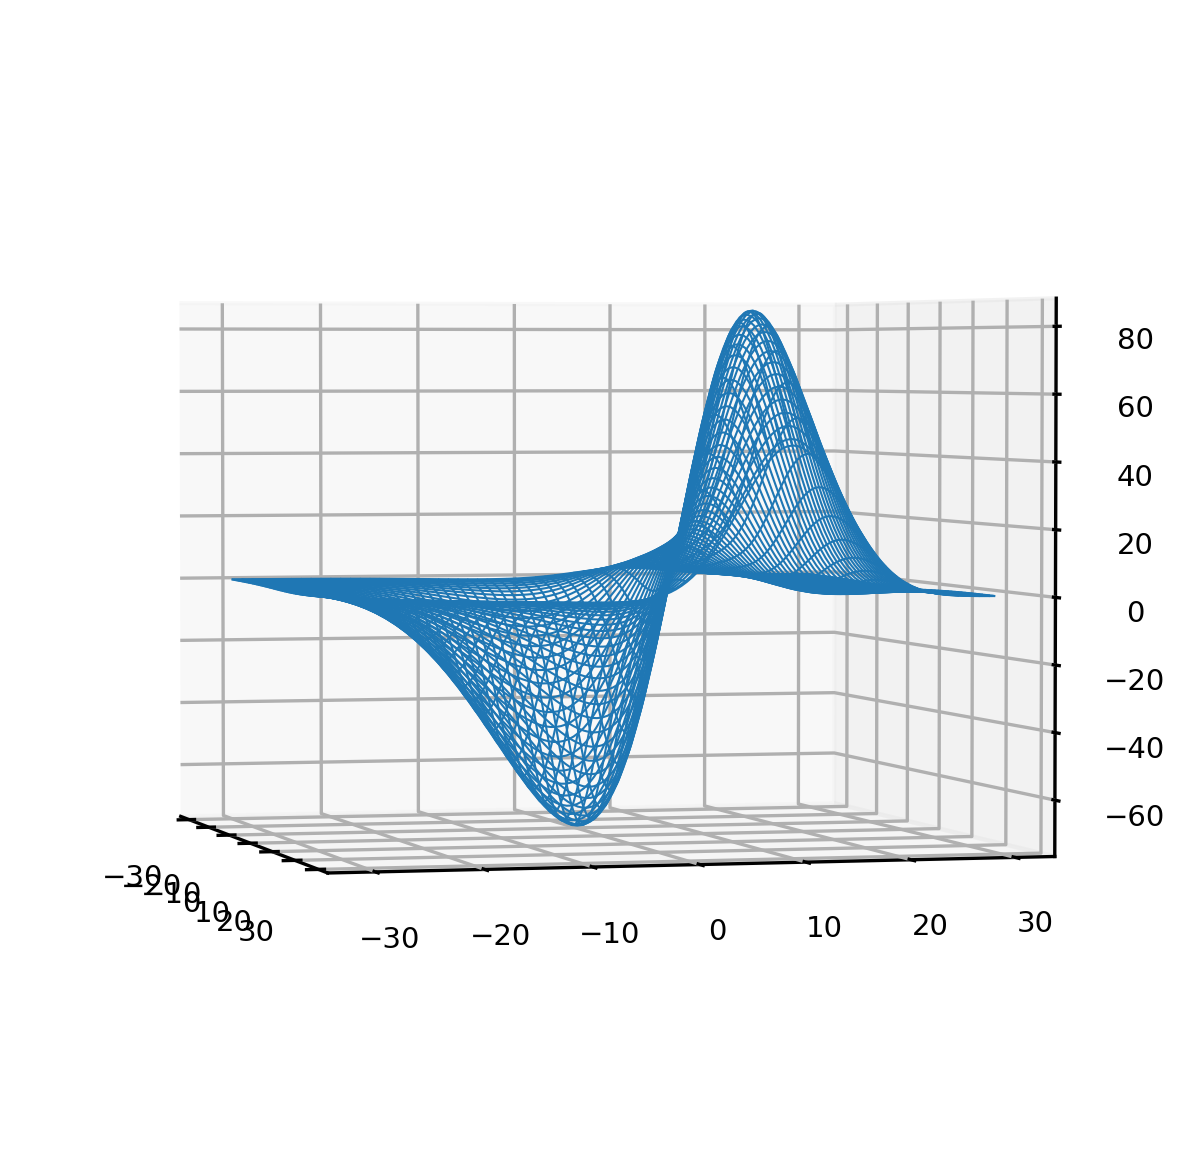

In [18]:
# 参数与损失函数共同构建的函数
p1, p2, MSE = axes3d.get_test_data(0.05)
plt.figure(dpi=300)
ax = plt.axes(projection="3d")
ax.plot_wireframe(p1, p2, MSE, rstride=2, cstride=2, linewidth=0.5)
ax.view_init(2, -15)
ax.zaxis.set_tick_params(labelsize=7)
ax.xaxis.set_tick_params(labelsize=7)
ax.yaxis.set_tick_params(labelsize=7)

In [19]:
# 确认整个参数空间当中MSE的最小值
np.min(MSE)

-73.39620971601681

In [20]:
# 我们从空间中抽取n个组合，n越大子空间越大
# 现在总共有14400个组合
# 对被抽中的点来说，损失函数的值就是MSE，对没有抽中的点来说，损失函数值是空值
# 因此，我们只需要找出没有抽中的点，并让它的损失函数值MSE为空就可以了
n = 10000

In [21]:
# 从0~14400中生成（14400-n）个随机数，形成没有被抽到子空间中的点的索引
unsampled = np.random.randint(0, 14400, 14400 - n)

-73.38392510772172


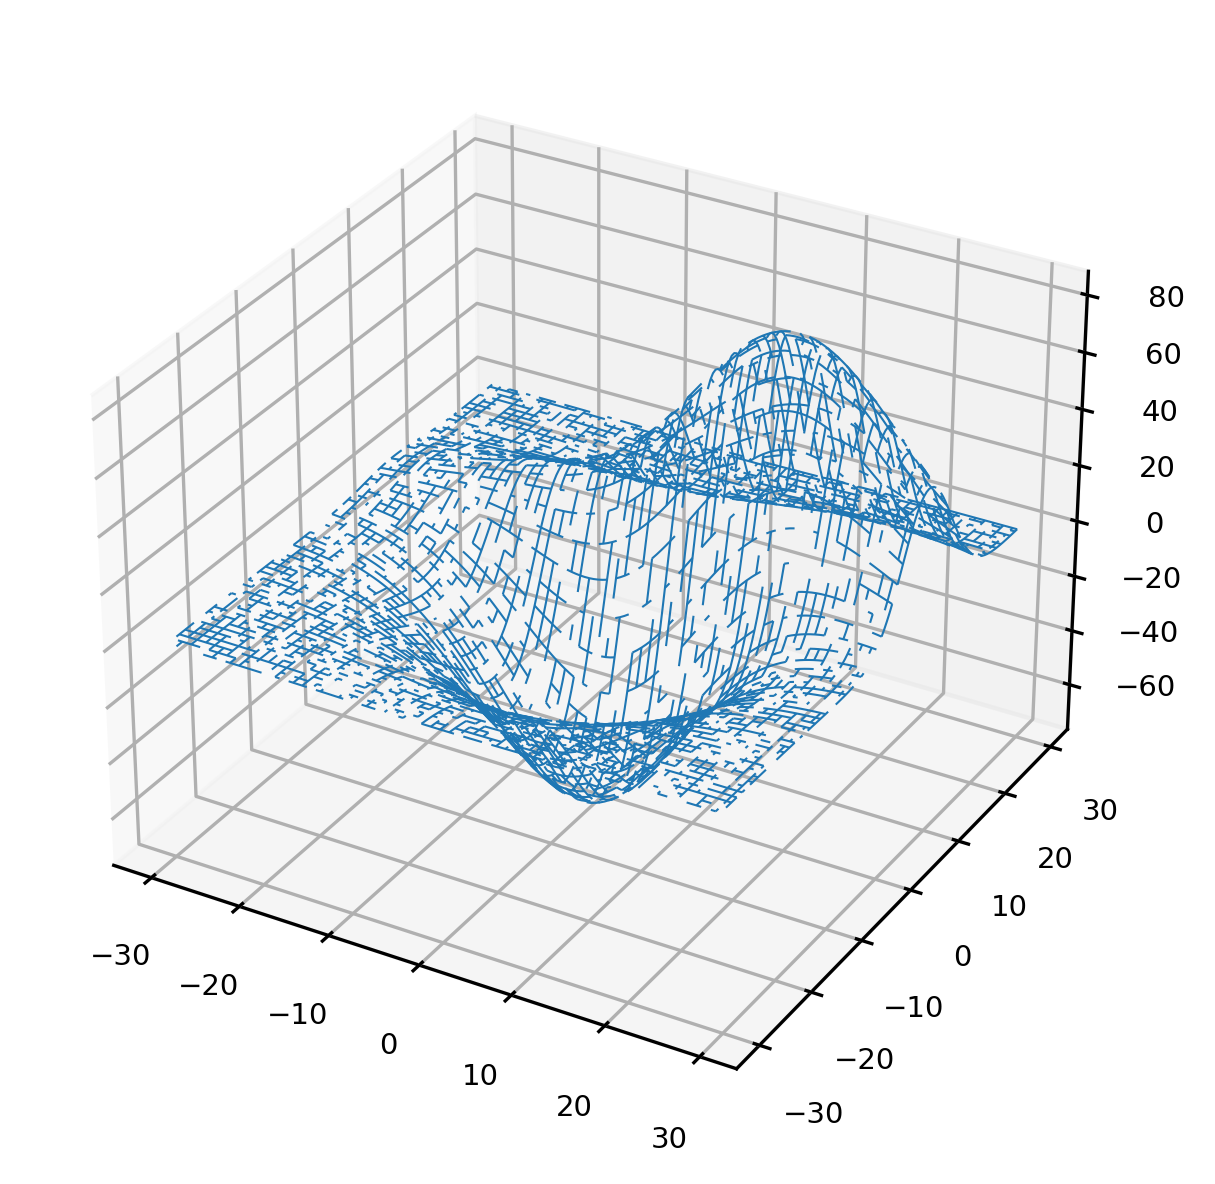

In [23]:
p1, p2, MSE = axes3d.get_test_data(0.05)

# 拉平MSE，并将所有没抽中的点的损失函数变为空值
MSE = MSE.ravel()
MSE[unsampled] = np.nan
MSE = MSE.reshape((120, 120))

# 参数与损失共同构建的函数
plt.figure(dpi=300)
ax = plt.axes(projection="3d")
# ax.view_init(2, -15)
ax.plot_wireframe(p1, p2, MSE, rstride=2, cstride=2, linewidth=0.5)
ax.zaxis.set_tick_params(labelsize=7)
ax.xaxis.set_tick_params(labelsize=7)
ax.yaxis.set_tick_params(labelsize=7)

# 求出当前损失函数上的最小值
# 注意此时因为MSE中含有了空值，因此要先排除空值影响，否则min函数会返回空值
MSE = MSE.ravel().tolist()
MSE = [x for x in MSE if str(x) != 'nan']
print(np.min(MSE))

In [8]:
param_grid_simple = {
    'n_estimators': [*range(80, 100, 1)],
    'max_depth': [*range(10, 25, 1)],
    "max_features": [*range(10, 20, 1)],
    "min_impurity_decrease": [*np.arange(0, 5, 10)],
}

In [25]:
count_space(param_grid_simple)

3000


In [9]:
# 建立回归器，交叉验证
reg = RFR(random_state=1412, verbose=True, n_jobs=-1)
cv = KFold(n_splits=5, shuffle=True, random_state=1412)

# 定义随机搜索
search = RandomizedSearchCV(
    estimator=reg,
    random_state=1412,
    param_distributions=param_grid_simple,
    n_iter=1536,
    scoring='neg_mean_squared_error',
    verbose=True,
    cv=cv,
    n_jobs=-1,
)

In [10]:
start = time.time()
search.fit(x, y)
end = time.time() - start
print(end / 60)

Fitting 5 folds for each of 1536 candidates, totalling 7680 fits


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.1s


30.48049549261729


[Parallel(n_jobs=-1)]: Done  89 out of  89 | elapsed:    0.4s finished


In [11]:
search.best_estimator_

RandomForestRegressor(max_depth=22, max_features=14, min_impurity_decrease=0,
                      n_estimators=89, n_jobs=-1, random_state=1412,
                      verbose=True)

In [12]:
abs(search.best_score_) ** 0.5

29012.905698465464

In [13]:
rebuild_on_best_param(search.best_estimator_)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


训练RMSE:11208.818
测试RMSE:28346.673


[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    0.6s remaining:    1.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.8s finished


In [7]:
import scipy  # 使用scipy来帮助我们建立分布

In [16]:
scipy.stats.uniform(loc=1, scale=100)

In [17]:
param_grid_simple = {
    'n_estimators': [*range(80, 100, 1)],
    'max_depth': [*range(10, 25, 1)],
    'max_features': [*range(10, 20, 1)],
    'min_impurity_decrease': scipy.stats.uniform(0, 50),
}

In [18]:
reg = RFR(random_state=1412, verbose=True, n_jobs=-1)
cv = KFold(n_splits=5, shuffle=True, random_state=1412)

search = RandomizedSearchCV(
    estimator=reg,
    param_distributions=param_grid_simple,
    n_iter=1536,
    cv=cv,
    verbose=True,
    random_state=1412,
    n_jobs=-1,
    scoring='neg_mean_squared_error',
)

In [19]:
start = time.time()
search.fit(x, y)
end = time.time() - start
print(end / 60)

Fitting 5 folds for each of 1536 candidates, totalling 7680 fits


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.1s


34.60238414605458


[Parallel(n_jobs=-1)]: Done  85 out of  85 | elapsed:    0.3s finished


In [20]:
search.best_estimator_

RandomForestRegressor(max_depth=22, max_features=14,
                      min_impurity_decrease=26.497676476036418, n_estimators=85,
                      n_jobs=-1, random_state=1412, verbose=True)

In [21]:
abs(search.best_score_)**0.5

29113.405359664695

In [22]:
rebuild_on_best_param(search.best_estimator_)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


训练RMSE:11296.682
测试RMSE:28455.434


[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    0.6s remaining:    1.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.7s finished


# Halving网格搜索

In [8]:
data2 = pd.read_csv('../data/House Price/big_train.csv', index_col=0)

In [9]:
x = data2.iloc[:, :-1]
y = data2.iloc[:, -1]

In [25]:
x.shape

(29062, 80)

In [26]:
x.head()

,Id,住宅类型,住宅区域,街道接触面积(英尺),住宅面积,街道路面状况,巷子路面状况,住宅形状(大概),住宅现状,水电气,...,半开放式门廊面积,泳池面积,泳池质量,篱笆质量,其他配置,其他配置的价值,销售月份,销售年份,销售类型,销售状态
0,0.0,5.0,3.0,36.0,327.0,1.0,0.0,3.0,3.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,2.0,8.0,4.0
1,1.0,0.0,3.0,51.0,498.0,1.0,0.0,3.0,3.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,4.0,1.0,8.0,4.0
2,2.0,5.0,3.0,39.0,702.0,1.0,0.0,0.0,3.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,8.0,2.0,8.0,4.0
3,3.0,6.0,3.0,31.0,489.0,1.0,0.0,0.0,3.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,8.0,0.0
4,4.0,5.0,3.0,55.0,925.0,1.0,0.0,0.0,3.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,11.0,2.0,8.0,4.0


In [27]:
y.describe()

count     29062.000000
mean     182798.864703
std       72379.404452
min       34900.000000
25%      139000.000000
50%      169092.000000
75%      203009.750000
max      755000.000000
Name: SalePrice, dtype: float64

In [10]:
from sklearn.experimental import enable_halving_search_cv
from sklearn.model_selection import HalvingGridSearchCV

对半网格搜索的类如下所示：

*class* `sklearn.model_selection.HalvingGridSearchCV`(estimator, param_grid, *, factor=3, resource='n_samples', max_resources='auto', min_resources='exhaust', aggressive_elimination=False, cv=5, scoring=None, refit=True, error_score=nan, return_train_score=True, random_state=None, n_jobs=None, verbose=0)

全部参数如下所示：

|Name|Description|      
|:--:|:--:|      
|estimator|调参对象，某评估器|      
|param_grid|参数空间，可以是字典或者字典构成的列表|
|**factor**|每轮迭代中新增的样本量的比例，同时也是每轮迭代后留下的参数组合的比例|
|**resource**|设置每轮迭代中增加的验证资源的类型|
|**max_resources**|在一次迭代中，允许被用来验证任意参数组合的最大样本量|
|**min_resources**|首次迭代时，用于验证参数组合的样本量r0|
|**aggressive_elimination**|是否以全部数被使用完成作为停止搜索的指标，如果不是，则采取措施|
|cv|交叉验证的折数|
|scoring|评估指标，支持同时输出多个参数|
|refit|挑选评估指标和最佳参数，在完整数据集上进行训练|
|error_score|当网格搜索报错时返回结果，选择'raise'时将直接报错并中断训练过程<br>其他情况会显示警告信息后继续完成训练|
|return_train_score|在交叉验证中是否显示训练集中参数得分|
|**random_state**|控制随机抽样数据集的随机性|
|n_jobs|设置工作时参与计算的线程数|
|verbose|输出工作日志形式|

- **factor**

每轮迭代中新增的样本量的比例，同时也是每轮迭代后留下的参数组合的比例。例如，当factor=2时，下一轮迭代的样本量会是上一轮的2倍，每次迭代后有1/2的参数组合被留下。如果factor=3时，下一轮迭代的样本量会是上一轮的3倍，每次迭代后有1/3的参数组合被留下。该参数通常取3时效果比较好。

- **resource**

设置每轮迭代中增加的验证资源的类型，输入为字符串。默认是样本量，输入为"n_samples"，也可以是任意集成算法当中输入正整数的弱分类器，例如"n_estimators"或者"n_iteration"。

- **min_resource**

首次迭代时，用于验证参数组合的样本量r0。可以输入正整数，或两种字符串"smallest","exhaust"。<br>
输入正整数n，表示首次迭代时使用n个样本。<br>
输入"smallest"，则根据规则计算r0:<br>
> 当资源类型是样本量时，对回归类算法，r0 = 交叉验证折数n_splits * 2<br>
> 当资源类型是样本量时，对分类算法，r0 = 类别数量n_classes_ * 交叉验证折数n_splits * 2<br>
> 当资源类型不是样本量时，等于1<br>

输入"exhaust"，则根据迭代最后一轮的最大可用资源倒退r0。例如，factor=2, 样本量为1000时，一共迭代3次时，则最后一轮迭代的最大可用资源为1000，倒数第二轮为500，倒数第三轮（第一轮）为250。此时r0 = 250。"exhaust"模式下最有可能得到好的结果，不过计算量会略大，计算时间会略长。

In [11]:
param_grid_simple = {
    "criterion": ["squared_error", "poisson"],
    'n_estimators': [*range(20, 100, 5)],
    'max_depth': [*range(10, 25, 2)],
    'max_features': ['log2', 'sqrt', 16, 32, 64, 'auto'],
    'min_impurity_decrease': [*np.arange(0, 5, 10)],
}

In [12]:
count_space(param_grid_simple)

1536


In [13]:
factor = 1.5
n_samples = x.shape[0]
n_splits = 5
min_resources = 500
space = 1536

In [14]:
for i in range(100):
    if (min_resources * factor**i > n_samples) or (space / factor**i < 1):
        break
    print(
        i + 1,
        f"本轮迭代样本:{min_resources * factor**i}",
        f"本轮验证参数组合:{space // factor**i + 1}",
    )

1 本轮迭代样本:500.0 本轮验证参数组合:1537.0
2 本轮迭代样本:750.0 本轮验证参数组合:1025.0
3 本轮迭代样本:1125.0 本轮验证参数组合:683.0
4 本轮迭代样本:1687.5 本轮验证参数组合:456.0
5 本轮迭代样本:2531.25 本轮验证参数组合:304.0
6 本轮迭代样本:3796.875 本轮验证参数组合:203.0
7 本轮迭代样本:5695.3125 本轮验证参数组合:135.0
8 本轮迭代样本:8542.96875 本轮验证参数组合:90.0
9 本轮迭代样本:12814.453125 本轮验证参数组合:60.0
10 本轮迭代样本:19221.6796875 本轮验证参数组合:40.0
11 本轮迭代样本:28832.51953125 本轮验证参数组合:27.0


In [15]:
reg = RFR(random_state=1412, verbose=True, n_jobs=-1)
cv = KFold(n_splits=5, shuffle=True, random_state=1412)

search = HalvingGridSearchCV(
    estimator=reg,
    param_grid=param_grid_simple,
    factor=1.5,
    min_resources=500,
    scoring='neg_mean_squared_error',
    verbose=True,
    random_state=1412,
    cv=cv,
    n_jobs=-1,
)

In [ ]:
start = time.time()
search.fit(x, y)
end = time.time() - start
print(end / 60)

In [ ]:
search.best_estimator_

In [ ]:
abs(search.best_score_)**0.5

In [ ]:
rebuild_on_best_param(search.best_estimator_)

以随机网格搜索作为对比，我们来看看随机网格搜索的结果：

In [ ]:
param_grid_simple = {
    "criterion": ["squared_error", "poisson"],
    'n_estimators': [*range(20, 100, 5)],
    'max_depth': [*range(10, 25, 2)],
    "max_features": ["log2", "sqrt", 16, 32, 64, "auto"],
    "min_impurity_decrease": [*np.arange(0, 5, 10)],
}

reg = RFR(random_state=1412, verbose=True, n_jobs=-1)
cv = KFold(n_splits=5, shuffle=True, random_state=1412)

In [ ]:
# 定义随机搜索
search = RandomizedSearchCV(
    estimator=reg,
    param_distributions=param_grid_simple,
    n_iter=800,  # 使用全域空间的一半作为子空间
    scoring="neg_mean_squared_error",
    verbose=True,
    random_state=1412,
    cv=cv,
    n_jobs=-1,
)

In [ ]:
#训练随机搜索评估器
#=====【TIME WARNING: 1个半小时~2小时】=====#
start = time.time()
search.fit(x,y)
end = time.time()-start
print(end/60)

In [ ]:
#查看最佳评估器
search.best_estimator_

In [ ]:
#查看最终评估指标
abs(search.best_score_)**0.5

In [ ]:
#验证最佳参数组合的效力
rebuild_on_best_param(search.best_estimator_)

|HPO方法|随机搜索|对半搜索|
|:-:|:-:|:-:|
|搜索空间/全域空间|800/1536|1536/1536|
|运行时间（分钟）|400|<font color="green">**100(↓)**</font>|
|搜索最优（RMSE）|1055.555|1068.281|
|重建最优（RMSE）|1054.359|1082.916|